# LightGBM: Retrain

### Setup

In [1]:
import sys
sys.path.append('../')
from src.load_data import *
from src.realtime_utils import *
from src.hp_tuning_functions import *

In [2]:
from darts.models.forecasting.lgbm import LightGBMModel

/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/statsforecast/utils.py:231: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  "ds": pd.date_range(start="1949-01-01", periods=len(AirPassengers), freq="M"),


In [3]:
import wandb
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: dwolffram (dwolffram-karlsruhe-institute-of-technology). Use `wandb login --relogin` to force relogin


True

### Configuration

In [4]:
NUM_SAMPLES = 1000
HORIZON = 4

ENCODERS = {
    'datetime_attribute': {'future': ['month', 'weekofyear']}
}

# Load best model

In [5]:
params = get_best_parameters('realtime-lightgbm-expanding-window', 'lightgbm', 'WIS_2022')

WIS_2022 of best run: 435.5334906946974


In [6]:
params

{'lags': 8,
 'model': 'lightgbm',
 'max_bin': 2048,
 'max_depth': 15,
 'reg_alpha': 0.5,
 'subsample': 0.8,
 'num_leaves': 31,
 'reg_lambda': 0.25,
 'n_estimators': 1000,
 'use_encoders': True,
 'use_features': False,
 'learning_rate': 0.01,
 'sample_weight': None,
 'min_split_gain': 0,
 'subsample_freq': 5,
 'use_covariates': True,
 'multiple_series': False,
 'colsample_bytree': 1,
 'min_child_samples': 10,
 'lags_past_covariates': {'agi-are-DE': 8,
  'agi-are-60+': 8,
  'default_lags': 1,
  'agi-are-00-04': 8,
  'agi-are-05-14': 8,
  'agi-are-15-34': 8,
  'agi-are-35-59': 8},
 'use_static_covariates': False,
 'lags_future_covariates': [0, 1]}

In [7]:
name = params.pop('model')
multiple_series = params.pop('multiple_series')
use_covariates = params.pop('use_covariates')
use_features = params.pop('use_features')
use_encoders = params.pop('use_encoders')
sample_weight = params.pop('sample_weight')

if not use_covariates:
    del params['lags_past_covariates']
    
model = LightGBMModel(
    **params,
    output_chunk_length=HORIZON,
    add_encoders=ENCODERS if use_encoders else None,
    likelihood="quantile",
    quantiles=QUANTILES,
    verbose=-1,
)

# Load data

In [24]:
targets, covariates = load_realtime_training_data()

In [9]:
targets_train, targets_validation = train_validation_split(targets, 2023)

<Axes: xlabel='date'>

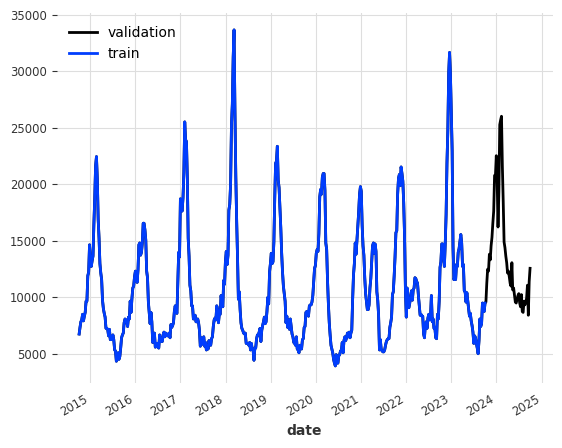

In [10]:
targets_validation['icosari-sari-DE'].plot(label='validation')
targets_train['icosari-sari-DE'].plot(label='train')

In [11]:
targets_train.end_time()

Timestamp('2023-10-01 00:00:00')

In [40]:
get_season_end(2023)

Timestamp('2024-09-29 00:00:00')

In [28]:
def exclude_covid_weights(targets):

    exclusion_start = pd.Timestamp('2019-06-30')
    exclusion_end = pd.Timestamp('2023-07-03')

    # Linear weights for the entire time range
    total_duration = len(targets.time_index)
    weights = np.linspace(0, 1, total_duration)

    # Adjust for exclusion period: Set weights to 0 during the exclusion period
    weights = np.where(
        (targets.time_index >= exclusion_start) & (targets.time_index <= exclusion_end),
        0,  # Weight is 0 during the exclusion period
        weights  # Linear increase otherwise
    )

    # Create TimeSeries object for weights
    ts_weights = TimeSeries.from_times_and_values(
        times=targets.time_index,
        values=weights
    )
    
    return ts_weights

In [29]:
t = exclude_covid_weights(targets)

<Axes: xlabel='date'>

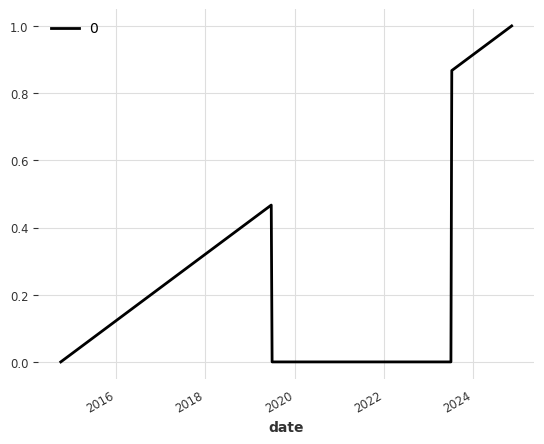

In [30]:
t.plot()

In [11]:
forecast_dates = sorted([filename.split('/')[-1][:10] for filename in glob.glob('../data/nowcasts/KIT-baseline/*.csv')])

In [12]:
forecast_dates = [f for f in forecast_dates if f >= '2023-11-16' and f <= '2024-09-12']

# Train model

In [15]:
RANDOM_SEEDS = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [16]:
for forecast_date in forecast_dates[:4]:
    
    path = f'../models/post-covid/{forecast_date}/'
    os.makedirs(path, exist_ok=True)

    targets, covariates = load_realtime_training_data(as_of=forecast_date)

    for seed in RANDOM_SEEDS:
        model_path = path + f'{forecast_date}-lightgbm_retrain-{seed}.pt'
        print(model_path)
        model = LightGBMModel(
            **params,
            output_chunk_length=HORIZON,
            add_encoders=ENCODERS if use_encoders else None,
            likelihood="quantile",
            quantiles=QUANTILES,
            verbose=-1,
            random_state=seed
        )
        model.fit(targets, past_covariates=covariates if use_covariates else None, sample_weight=sample_weight)
        model.save(model_path)

../models/post-covid/2023-11-16/2023-11-16-lightgbm_retrain-1.pt
../models/post-covid/2023-11-16/2023-11-16-lightgbm_retrain-2.pt
../models/post-covid/2023-11-16/2023-11-16-lightgbm_retrain-3.pt
../models/post-covid/2023-11-16/2023-11-16-lightgbm_retrain-4.pt
../models/post-covid/2023-11-16/2023-11-16-lightgbm_retrain-5.pt
../models/post-covid/2023-11-16/2023-11-16-lightgbm_retrain-6.pt
../models/post-covid/2023-11-16/2023-11-16-lightgbm_retrain-7.pt
../models/post-covid/2023-11-16/2023-11-16-lightgbm_retrain-8.pt
../models/post-covid/2023-11-16/2023-11-16-lightgbm_retrain-9.pt
../models/post-covid/2023-11-16/2023-11-16-lightgbm_retrain-10.pt
../models/post-covid/2023-11-23/2023-11-23-lightgbm_retrain-1.pt
../models/post-covid/2023-11-23/2023-11-23-lightgbm_retrain-2.pt
../models/post-covid/2023-11-23/2023-11-23-lightgbm_retrain-3.pt
../models/post-covid/2023-11-23/2023-11-23-lightgbm_retrain-4.pt
../models/post-covid/2023-11-23/2023-11-23-lightgbm_retrain-5.pt
../models/post-covid/202

# Forecast

In [17]:
RANDOM_SEEDS = [1, 2, 3, 4, 5 , 6, 7, 8, 9, 10]

In [18]:
NAME = 'lightgbm_retrain'

In [19]:
#forecast_dates = sorted([filename.split('/')[-1][:10] for filename in glob.glob('../data/nowcasts/KIT-baseline/*.csv')])

In [20]:
targets, covariates = load_realtime_training_data()

In [21]:
def compute_ensemble(forecast_date, export=False):
    dfs = []
    for seed in RANDOM_SEEDS:
        print(seed)
        model_path = f'../models/post-covid/{forecast_date}/{forecast_date}-lightgbm_retrain-{seed}.pt'
        model = LightGBMModel.load(model_path)
        df = compute_forecast(model, targets, covariates, forecast_date, HORIZON, NUM_SAMPLES, vincentization=False, probabilistic_nowcast=True, local=True)
        dfs.append(df)

    df = pd.concat(dfs)
    df = df.groupby(['location', 'age_group', 'forecast_date', 'target_end_date', 'horizon', 'type', 'quantile']).agg({'value': 'mean'}).reset_index()

    df = df.sort_values(['location', 'age_group', 'horizon', 'quantile'])
    
    if export:
        df.to_csv(f'../data/post-covid/submissions/{NAME}/{forecast_date}-icosari-sari-{NAME}.csv', index=False)
        return df
    else:
        return df

In [26]:
df = compute_ensemble(forecast_dates[5])

1


In [ ]:
forecasts = []
for forecast_date in forecast_dates[:4]:
    print(forecast_date)
    forecast = compute_ensemble(forecast_date, export=True)
    forecasts.append(forecast)

2023-11-16
1
2
